# The following pdf file is a combination of all the simulation jupyter notebooks
## The file contains four simulations
<br> 1) A drone stabilizing itself under wind dusturbances at the origin
<br> 2) A drone stabilizing itself while following a circular trajectory under wind dusturbances
<br> 3) A drone finding the optimal path to reach a vertical orientation
<br> 4) A drone finding the optimal path to do a full flip

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mp
import matplotlib.animation as animation
import IPython


MASS = 0.600 # mass of the quadrotor
INERTIA = 0.15 # inertia of the quadrotor
        
LENGTH = 0.2 # length of the quadrotor
        
GRAVITY=9.81 #gravity constant

DELTA_T = 0.01 #integration step
        
NUMBER_STATES = 6 # number of states
NUMBER_CONTROLS = 2 # number of controls
        
            
def get_next_state(z,u):
    """
    Inputs:
    z: state of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    u: control as a numpy array (u1, u2)

    Output:
    the new state of the quadrotor as a numpy array
    """
    x = z[0]
    vx = z[1]
    y = z[2]
    vy = z[3]
    theta = z[4]
    omega = z[5]

    dydt = np.zeros([NUMBER_STATES,])
    dydt[0] = vx
    dydt[1] = (-(u[0] + u[1]) * np.sin(theta)) / MASS
    dydt[2] = vy
    dydt[3] = ((u[0] + u[1]) * np.cos(theta) - MASS * GRAVITY) / MASS
    dydt[4] = omega
    dydt[5] = (LENGTH * (u[0] - u[1])) / INERTIA

    z_next = z + dydt * DELTA_T

    return z_next


    
def simulate(z0, controller, horizon_length, disturbance = False):
    """
    This function simulates the quadrotor for horizon_length steps from initial state z0

    Inputs:
    z0: the initial conditions of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length

    disturbance: if True will generate a random push every seconds during the simulation

    Output:
    t[time_horizon+1] contains the simulation time
    z[4, time_horizon+1] and u[2, time_horizon] containing the time evolution of states and control
    """
    
    t = np.zeros([horizon_length+1,])
    z=np.empty([NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    u=np.zeros([NUMBER_CONTROLS, horizon_length])
    for i in range(horizon_length):
        u[:,i] = controller(z[:,i],i)
        z[:,i+1] = get_next_state(z[:,i], u[:,i])
        if disturbance and np.mod(i,100)==0:
            dist = np.zeros([NUMBER_STATES, ])
            dist[1::2] = np.random.uniform(-1.,1,(3,))
            z[:,i+1] += dist
        t[i+1] = t[i] + DELTA_T
    return t, z, u
    
    
def animate_robot(x, u, dt = 0.01):
    """
    This function makes an animation showing the behavior of the quadrotor
    takes as input the result of a simulation (with dt=0.01s)
    """

    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(np.round(min_dt * 1000))
    else:
        steps = 1
        use_dt = int(np.round(dt * 1000))

    #what we need to plot
    plotx = x[:,::steps]
    plotx = plotx[:,:-1]
    plotu = u[:,::steps]

    fig = mp.figure.Figure(figsize=[8.5,8.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4,4], ylim=[-4,4])
    ax.grid()

    list_of_lines = []

    #create the robot
    # the main frame
    line, = ax.plot([], [], 'k', lw=6)
    list_of_lines.append(line)
    # the left propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the right propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the left thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)
    # the right thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)

    def _animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        theta = plotx[4,i]
        x = plotx[0,i]
        y = plotx[2,i]
        trans = np.array([[x,x],[y,y]])
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        main_frame = np.array([[-LENGTH, LENGTH], [0,0]])
        main_frame = rot @ main_frame + trans 

        left_propeller = np.array([[-1.3 * LENGTH, -0.7*LENGTH], [0.1,0.1]])
        left_propeller = rot @ left_propeller + trans

        right_propeller = np.array([[1.3 * LENGTH, 0.7*LENGTH], [0.1,0.1]])
        right_propeller = rot @ right_propeller + trans

        left_thrust = np.array([[LENGTH, LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        left_thrust = rot @ left_thrust + trans

        right_thrust = np.array([[-LENGTH, -LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        right_thrust = rot @ right_thrust + trans

        list_of_lines[0].set_data(main_frame[0,:], main_frame[1,:])
        list_of_lines[1].set_data(left_propeller[0,:], left_propeller[1,:])
        list_of_lines[2].set_data(right_propeller[0,:], right_propeller[1,:])
        list_of_lines[3].set_data(left_thrust[0,:], left_thrust[1,:])
        list_of_lines[4].set_data(right_thrust[0,:], right_thrust[1,:])

        return list_of_lines

    def _init():
        return _animate(0)


    ani = animation.FuncAnimation(fig, _animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=_init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVSltZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA3PZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeG1b0HzRSLKwuVHEWQOVRUoy+aQv5T
wMpaf2UottkWgT/ID+oG9r7WWb/6FhnvI/tWfsoZIM1tUI6l3V5X2pPPhJkazbnSx9VxsnoAAMZv
pRjQgJOUBoqz5UbH+TQGFy+rbX8BtNygAQ8aFLloHRoAa3lrwpGqamZH/Oi6YYXC4O8KDSrMtGoy
fOHiIfjPM6A72g1VRQ+FcaX2sjQZMpL/hSy2QVOwedoGKBwNE9gJAZBt/hSKaTgFhvnfOTo3vsy9
JS+vltalleg7obgKKj2c4a2b/zeXY7WEvIlhshKK/5b+YpCHeaSfceW8XXJ9V9Ki150t29vqbq5X
y0/68KlmiDq0Apc+ZdvsYETaOEO5b8o0ujSeIOIgkkAuZBD5jrDt0BncA/IhXV5Eb7+quCWHkqxq
ik6nQYEbKiak8FwCxkIiwDC8PVq6M6hDZDN0HBeMrBD+fwzop6azjkUAqF7ibfMTUvisv/8WMQl+
Yg5aeyfQH/ZGO5RpAR5GKyOMrrD3GFOF15QcfwW3vacMAAADAXwtHWXDQPFwdgF1CUqCXUqRwKxH
FQu+MXlzNKt909ZbpZ0G2nWmJ8otdTkMmv7Vw83YQqWfgah/wkFKdeqcRo6g8lwDjC7vzNfpeZsT
aaCsaYVoCrRiyvTG0E4RlQ8eW1Tk7vw46UFnSf/tYL9thvWh6c9eo2//7wSi0JzASQqS/PjmflIU
OtHFEPpU7QyQ5suJgl+KvdGgtaJwRwcMcXjCQRNzvjAgwzuRotpH50B9moOK2WV0+A2QE2m13QPK
wII4q+vgKzYM001ww5/4gYAyO59vHrTZmXeNL/JkMBzKP/pUDTBJBfj2Echdn9b2VbHKwoW3p7vk
rFdxvZIAeMRm5FaZtpDGIA1P5QZLrrZ5sD0QoHBfi7+WtzR7lgAJsdzTgDfwmb/AA86Ff40ivqhz
nUMPe+ikeYZEj6keeRZtoYLuxwnwqWOjG2KGOOJ3k/H5fSeyUgcAywdjDyJU5Qf/rVo18U8BijNq
H3f61KG9sMvuYX9VbR+wbfz32r6aEVxPOlqIAmGZRZruf2l8EZ7EiatY/uLBLuYYInnLgUaVgHWi
iva7YcSb9K//nyFwZvpPUM0jAasfofAKeoAjLLCTp48IXf6146bnv+IKE6Cy4/22CDMmQLZv9P0B
nd7vB9igLf+TuQECtXb1g/1eCltA1ZjmstcregwDHUWwLN7+RKLQuNStR7+OBD+1crJkOvemuig9
P+6b8rs3buj6BM1ZbUGQbwJNjYtZgaCuargyyLzHBLNyjIAAAAMAAAcNGVcdoGk3qQgapG29nvtg
yflgnEZREGG8WcNIbbbJXthMLH6NvZFqDq0/vS6Xi4AVKNBMxXM8nHi//KARLJv6QP294rPYXoK3
FaTndD1XYntSiIrcKAfG2p8G4yH+2s9Dvx1JCKG1p6m3jEVZayTTbTvB9oHgdssmp2ciMlz8xVhB
j20Zap7E8BpwhYYGe/PoNZrSu6rGhnNvyBIBlTksjEwLx2WvQWmDL/5+gevU8obM2MBtBtNutm8+
f3r5MsHQ54oW1vFRn5T22yJocLvC3dZKVjocVusdvp8e2iskZ63hTU8REn/Iv1dMiw8v1mdtS0Hb
fACS/uySWWqgLdewoiBfiEWTVPwNAZtIJMczpVZOrlsI5wWgFbcEC6+z1By+mqDiFOXIdCvZC3Yy
Hixp////X/L2mPt2+bRQlBumtnRYLibejGCkMCy6c+z7uJPzsqLXY/hOUgdr9CQzkdEmotwx1g8j
t5T2wOQE+05vTJPxbcJyJ9s8oo62DSBR0UMegVFwFvn/ydnilZuJDXHimjMx+qS8vzTm87PmyeGf
eRFWcToHxCkge4Q9Nx1d++fesOfP9ptEwFJ0VqMVw6pjCRMczrXLOCsmnx6s2sBz2gLRgXWf1xRc
ZfnTCDyYVQc2M6xo+BnM3OmNAAADABuAAAcfURYjj49WfIp6m65VSVc/bU4d+gJ3HfrsWu4hHmCW
/hree7YVfPxHToiV1UmpJk21hi63k/ucqHkURDOq7YDXTu/BdFtfSQlT9Qi3IfpKCOIndiy8AAbX
bWFcoVSaO053OEsjqw9/P8xnXka5PKymkNFi9RbBLLGlq7NvHvy6NORsX8OnzTbkpzLmV/MhLLRb
BEN9lh8YSJTS0smuTdhj8jK8bez3FWk85IkLcTs4D5jQR6AtI4T25Sy1rfk5X2EmkBp3ny19PdMZ
HfUstpj5G6YSnBGw+WlBL/9McloqvbUn8KDta9Y3WvuWf+R/T/lbXj/p0SbwjJQLGFbtQ+9nuQgN
0YQtAAADABmAAAboqXp0ffKmc1VOQWee9R8L7e8P8JElffs+WSLepe4GuPjZGVMPyShvovOn/y5I
jsCiM5X4xz4UOOFoXaEUFitCGbZ4d27WhaU4rJpTBZlFNVk6Ojdy5mrmzahwg6EMMqh7qL3GB1P5
HRp/vTA/+sM6qZ/ZBy9xrZUiQr54oD2Kajv/3gpfi9bFe6MjvkPXqhT6/8IGL42QspqR0SnrYGQv
0C6URSDE7wsNPGjpIx2c2GFBzsW+nJXWggZD+vZA2HN8JVogZRInqlm0jdfp0Ws+3jkhIvir/DHF
R6ih/nbkFtlrFoow8R0kQ

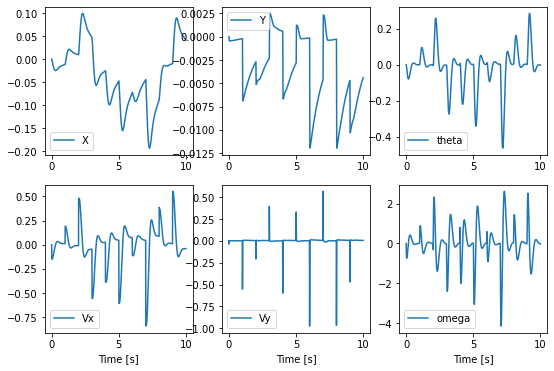

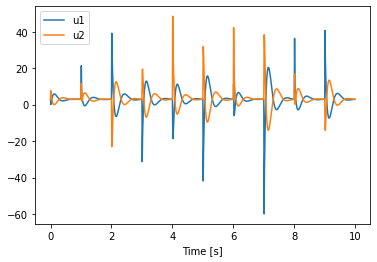

In [4]:
# Drone stabilizing itself under wind disturbance

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

# Linear Quadratic Regulator
def stable_LQR_controller(state,i):
    # Set origin points
    z_origin = np.zeros([quadrotor.NUMBER_STATES])
    u_rest = np.array([quadrotor.MASS*quadrotor.GRAVITY/2, quadrotor.MASS*quadrotor.GRAVITY/2])
 
    A,B = get_linearlization(z_origin,u_rest)
    
    # Cost matrix for state
    multi = 600
    Q = multi*np.identity(quadrotor.NUMBER_STATES)
    Q[1,1]=multi
    Q[3,3]=multi
    Q[4,4]=1
    Q[5,5]=1
    
    # Control cost matrix
    R = 0.1*np.identity(quadrotor.NUMBER_CONTROLS)
    
    P_prev = Q 
    #solve Riccati recursion
    for i in range(1000):
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@P_prev@A
        
        Pn = Q+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn  
        
        P_prev = Pn
        
        K = Kn
    
    
    u_stabilize = K@(state-z_origin)

    u_original = u_stabilize + u_rest
    
    return u_original

# Plot the resuts
horizon_length = 1000
z0 = np.zeros([quadrotor.NUMBER_STATES,])

# Set disturbance = False for NO wind
t, state, u = quadrotor.simulate(z0, stable_LQR_controller, horizon_length, disturbance = True)
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Animate the results
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABY9ltZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA3fZYiEABD//veBvzLL
XyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuH+4x2xPbAAAArgAVwJEflNQL71nT4ADkMV
VPbRK84RdyqRUb6gRRR3eFQvVE+KTOH603JMImy4IeauYGfkC5QJLIc84ErblKTJbTqwzR4Yl3kc
jYnKfKjcI37bKL3OEZMXCcYw2mayGHGQhOtp/ofbg//2++sGGRgJage3e3p1cJ4vwELvqcBAznSW
jm9uE69bPcEEqxzH/ygnG5ls/l7oCONpPHi5MF+as7jzx/Pn7MizWmbqaZj//zh/iGvAv6vtDl6D
e7P7Y4DhV2eLgcCksVaXcHtOmofHP+XLaHAmJ9nOb1sAYDnR7Bbm7GOL7vH6I4g0440xkqrfyKix
bdogVk/3NYLyXWwdxPxsE8m/etAoXWBKOqO9aFAABgatSp7uaxP9AouKcJ/qFOvwIjh5t+3Ikc7V
hQAjzRmZMHpf3cc0OTEQ7Nd8BtRTcvFsZlQjt93X8zvGgO9oNVTOKjQtTm1CZRzvUt+8hHC7EXTV
yYv076PieFfPo2/wpFNJwCxgp9AbPY7s8Wh9Ngb4C7tP4uNXU5O88hjnBTu2tIGoUraDGlPKPlZQ
7DriLXvFLoTQDff+nRG69DP2tJz2TXHopDmBf7GS1UUSFZ7rpIWhYVxVhOpyLxwzfI08TgHSin5Y
/vSXaTxTrK7bb/6J2dPbxXCa27ntoMNWy85Zym8Li/sYxf+ptDgfz7iBqCaLK8EIyULWhAbzvOq0
j254mJ3rLA2YgeJSACvhZkMNaPiClrp+ME7Q5g/UFZG1KrrOYVp5woQOYWA2WUXChDj9hwOfFJTd
isrvDF2uWtxN9blABeUQmBAbDh5GA0AAAXuu3YZCVbrID4PrpT/9OrjsxnuAfB4qBYkTW+A4ct0s
6BvQh6m+UWupyGTX9q5xXsIVLPwNQ/4cVR1PtOI0dQeS4Bxh0VV0v0vM2JtNBWTcDw611m57Wbiq
CbdE/bqu1Tk7vw46UXqS/BN+okJWdkqSHpz16pp//SDAtgxBiRS7WKska1Mka9crv9ZL9oj2fdLo
gy2C/uD8bi1o4nqN+ls4wnVpYefCTnhFpgWnd6IDl0EJCb3HbCuQ9SIZG+4s8MgEicGPzfFqTfkh
V6YMIX+vnjkjywEDF3DO16JTj7nvkyJyvCf/vRlExpwc61trOSqRlqWykRANGfQf9X9MYyc9Pttt
Wna/W/Lf6wO4IysVxZJta+dYFLvvgmAAAAMAuYV8Oxd48/kYXnswI2nmMLfWOUUu80OKmcaFpH9k
skTW2jspWQVl/VP6hn1jSN6H8Zu6wC8EbmYw8WaI/X/9ipGvioNHMKH5nsMpvUztcZEoD+kK8GTl
jg/laeaZxMc5xol7NP/+2kcP9MJe0v3svZmm3xMeWCvRa2/sFdMetFFe12w4k36Sf7lYWVNp26hk
EXjniOh7gVIQz0P9cbNHBeQBu4Y1vAiraWYgoVHFd5IVVC9Tp2rqiwXBqyDA7Lfy44eXJF+U1rti
D9ZJOpqgwacVSCgxziohh8GbWRjxzBz0K0rXSQEBY5SBFCkc1EBdaDOhN2ee0eQlEMkR2SxUsa6P
sDN2rYbLfMQAnFmgfIjfAAADAAAf+vfXwjj0bBJ448w7YenXKwON7lzlhnbHdThRWJGShAYbczKf
G9jqx7qxApenbs1z/YIlPANUjbez32wZPywfdhf7cwfQzgdrd/ZKpRW/+8bQ29dkN/9oEpNOwP+B
wpzBVXJoGiP7/PW9f1zjPv3TobP44gU4zZeXCiFCR6KMsYHa0GecbMEibqbm66XdOh6X+CxbSfuM
31IXmdV8sG9f+hrBAC1sth61sYBmVcTHf2CggIdy4yrWQfDmP+nnMQs6ZArnbAtq7Zx5ULCR6XSS
gi7FxzuptswftGnj7sQXavbB1YvR0EmpghhZ3FXRIqYHzbzLB7ePowps0ZyJGDVUCUFtxouqZur7
0SZzL9o3kYJbRPg0Ogj2rjsZ/eBeGodCvZU1IRRAAXvsgObT0dM/fq7CTVrS41pyyuosuTHDZyKO
XUXvrh5/VLTxZJhJBAIy3UXzUaM7Ujol9Z1+f3nKulKVlPY45G6QZGDy00J6oMnmFjamcelJq03I
KVem+kzOxmUFPfwgmH3O3C3BqYCAAxZbr9CYA2z+M/sc8dcP9r7OTBuKyDKqPzhzDwYm92mcZbZR
DR4x7OORVbSENXHglnrmuwTg/GYQP+rhg4qAABizAABo/UizWXEFcXhHL9QYsgXzKCb0v+vDfUW5
5uNP1PE11gSz1z3bCr5+I8OqiH9k1JMm2sMXW84H3DEEIkQ/g1oq107vwXTDxPUBkal71t9xzJnH
v6AfM5VaPEQ2TNFeq4yQs//ha6RdczTd0M3nVyyGtbQ50dopEQwJd3lzrloHrlmR4fZh/Loc0PgF
d+cSa3E96vfQ/J14pP4bfZrB//FuPQfV0dyLtdR7lTESZO2HtrRpDHMfea4JT3aGZLrsPsvPNqQI
QUYTwKhhNcuOgGhaYu83wdo/gv7ORNKLkVMast/+1JhpRZzLGGFK81pl8zWtKP+Uo0/LpwznalbV
PeL1x76soZkkHFwAAAMAAAMAQxzjZm85WR5qqcgs896j4X28S38gp9sW7oddVQavVzDHxsjKmH5J
Q30Xn234nvGQB7fk4PNOVihm2kwHCqtLt5Zpv5VBtT6zIgLLliQVIP1p6lCFeCmaM9w0mVNIkkJE
UQTd123MSAAED6VfF8XfvN2/2zdKtE5+1yOdqqNzvhIZKLGFt6B/fSonW9/ZnFe5cmmHa/QkM5HQ
/z1qrbvTiOb23g7G5tL3WkjMHYD4ahz7VqkqVCMVsGb3wzujjO0wReGzr5ZtI3X5z4QrTQ9NSNRV
/hjjumczDcd8Z7jRLRRhU

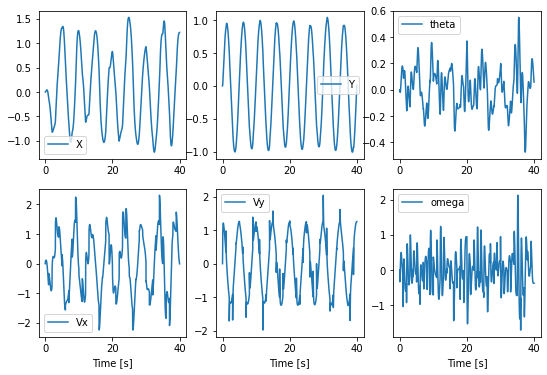

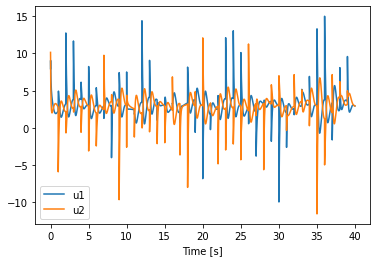

In [5]:
# Drone following a circular trajectory under wind disturbance

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,DELTA_T,0,0,0,0],[0,1,0,0,-DELTA_T*(u[0]+u[1])*np.cos(z[4])/MASS,0],[0,0,1,DELTA_T,0,0],[0,0,0,1,-DELTA_T*(u[0]+u[1])*np.sin(z[4])/MASS,0],[0,0,0,0,1,DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-DELTA_T*np.sin(z[4])/MASS,-DELTA_T*np.sin(z[4])/MASS],[0,0],[DELTA_T*np.cos(z[4])/MASS,DELTA_T*np.cos(z[4])/MASS],[0,0],[DELTA_T*LENGTH/INERTIA,-DELTA_T*LENGTH/INERTIA]])
    return A,B

cos=np.cos
sin=np.sin
#Function to generate the trajectory points along the circle of radius 1 (z*,u*)
def generate_trajectory_points(TRAJ_TIME):
    t = np.arange(0.,(TRAJ_TIME+DELTA_T), DELTA_T)
    phi = 2*np.pi*t/TRAJ_TIME
    
    z_traj = np.stack((np.array(cos(phi)),np.array(-sin(phi)*2*np.pi/TRAJ_TIME),np.array(sin(phi)),np.array(cos(phi)*2*np.pi/TRAJ_TIME),np.repeat(0,t.size),np.repeat(0,t.size)))
    u_traj = np.stack((np.array(MASS*(GRAVITY-(sin(phi)*4*(np.pi**2)/(TRAJ_TIME**2)))/2),np.array(MASS*(GRAVITY-(sin(phi)*4*(np.pi**2)/(TRAJ_TIME**2)))/2)))
    return z_traj, u_traj

#Function to solve LQR which follows a trajectory    
def solve_LQR_trajectory(Q, R, z_traj, u_traj, N):
    '''
    A, B, Q and R are the matrices defining the OC problem
    z_traj is the trajectory of desired states of size dim(x) x (N+1)
    N is the horizon length
    
    The function returns 1) a list of gains of length N and 2) a list of feedforward controls of length N
    '''
    
    
    n=N-1
    K_gains = []
    k_feedforward = []
    P_prev=Q
    p_prev=-Q@z_traj[:,N]
    
    while(n>=0):
        
        A,B = get_linearlization(z_traj[:,n],u_traj[:,n])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@P_prev@A
        
        Pn = Q+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R)@B.transpose()@p_prev
        
        qn = -Q@z_traj[:,n]
        
        pn = qn+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        n=n-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    return K_gains, k_feedforward
    
# Controller
def circular_trajectory_LQR_controller(state,i):
    j=i
    
    if(i>=N):
        while(j-N>=0):
            j = j-N
            
    u_real = K_gains[j]@(state) + k_feedforward[j] + u_traj[:,j]

    return u_real
    
    
    

#Set time to finish circle
circle_time = 5
#generate trajectory points
z_traj,u_traj = generate_trajectory_points(circle_time)

#number of points
N = int(circle_time/DELTA_T)
multi = 500 #multiplier for cost

#Define state and control costs
Q = multi*np.identity(NUMBER_STATES)
Q[1,1]=multi
Q[3,3]=multi
Q[4,4]=1
Q[5,5]=1

R = 10*np.identity(NUMBER_CONTROLS)

K_gains, k_feedforward = solve_LQR_trajectory(Q,R,z_traj,u_traj,N) #Set K_gains and k_feedforward as global variables


horizon_length = 4000
z0 = np.zeros([NUMBER_STATES,])
z1 = np.zeros([NUMBER_STATES,])

#Set disturbance = False for NO wind
t, state_list, u = simulate(z0, circular_trajectory_LQR_controller, horizon_length, disturbance = True)
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

#Animate the results
animate_robot(state_list, u)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVattZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA2uZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeDDGblDP4oiq80WQOVQ/kvRcX6GntS
Tyf2SkA1tyCNIyktbublNs2xhPCwz3kf2rP4S8jvTxqEdS7q8r7UnnwkyNZtsidmfggEoAALuDpT
UqgO2Nyc/nyo2P8mgMLl9W2v4DablAAh40KXLQOiQA0eTXhSNU48dP9tF0wwuFwd4UGlWZaNRk+c
PEQ/GeZ0B3tBqqih8K40vtZGgyZSX/Cllsgqdg87QMUDgaJ7ASAyDb/CkU0nALDfO+cnRvfZl6Sl
9fLa1LK9B3Q1wTbHr5w1s3/m8ux2rJaVHDZCUV/y38xSEO80k+48n4ueT6r6VDh4ujgolzbZLj9d
/49jd6q5J0Apc+ZVVkguqgptHCHct+UaXRpPEHEQSQlTAE+C6VUm1cCu4Xv2VqNhLgJbIEN0ANjG
Wy8MVq3JKMY05hpbR64iE/eKC9o4qlYJ5IPqKNdXjh1djG4LNrYxnnanJ8qnXDyjMpvpBy09k+gP
+yMdyjSAjyMVkcZXWHuMKcLrx2zJKo0vJ/oAAAMAqAaU9touYtN2AXUJSoJdSpHArEcVC749O5Sb
2hP9XLdLOhAU8MxPlFrqchk1/bzt+OWjbP8DUP+FdW7r1TiNHUHkuAcYYV+Zr9LzNibTQVj0cmkt
RAijy+vzHaNKiM8D+nJ3fhx0orGBGXhtICKlMpj0569SMT/6QYJoJ7/xtTcttFvjmflIUOtHGJdS
etk5uIQtaJwRwcMcX0OO6b/SXqJhncjRbSP1GER24YFKEJGaOnc/q1LrTv5m2Kvr4Cs2DNiAZMTC
fKwpNogcMkFT4BUVH9N7EM/xQxf/ei8FycjOksOGC7P63sq2OVhQtvfRfJWK8HA0XS8bVdxNzjb1
OgGgEVKO0GnnRJKKahPv6SFlwBYTpYADak7hcBZgtWs3/3OhF+NWRY6JOE1gf5IdQKhE4aij2J6/
vMF3Y4T4VbCxjbFDHHE7yfj8wt7ZKQOAZYOxh5Gmqn//crRr4p4DFGb+udQ7lWGjbglI/7P8sze8
GrmOJXNh2vK0DvfS1EATDMhBt6FGxwjGhLQ0rCGYeU2WMofxZLpiaigboKLHaNpuIR2zr/58gb7U
IvG0rEZ5VI+dD7kPuhGch+paVGtEktNRc+pM9/oGduN9QQZzXFNfqWlRrRBkEBTSSITkXS1Ds/8M
Xl3VmOay10svjSAqVjfUfu/Zv3sutkkql6zfsu02zUzr4rw07doGaZ8kjcsxsNWj+kZo9UOQvdk/
pqayyjx7jMQWT+1q5TX4vQAAAwAADfIyrq8FguFlpKxohclG7BIOoClRCURBhvFnDSG22yVRzboy
fTyxNFNc85v6VJ6uEMJyMx/8G8RZedHRITQl9EvlAJOgsmentWlky9rLIGjCINNxbYIP7a3UO/HU
kIKqh1j5ajfD2uRonRB7wfaB3NH5kbsyDBFLo7HtE0pRET3hYp34f/9cFr1Mdv893tkA+TIje4BS
BYxSLBaJcHP6FJuhuZuQNKQ4T/qR58FZFovKZO6MBuu4GXoPvN05uu+HgnxY6RT7Uv/YoIuzWrJr
A/XHwO7ktfvJtTgoyxRVs3CKWdD5E6rQoRlM7KkDtgQT92STIOjlr3XCaE2l0kqZ9jx5NyumU2fu
WyV48eYTmGCkK2ifBodBIMWwmjWMDg845bJ9TNnIrthIYS9MR2W1ZuzRvFySZ9Xywx2OAeHMycY3
j7F+L0LL/nnYef8pE5dlfCtckDtfoSGcjomMGro3il/zTZJ3gEleSTVhJ0S77e1v7l/CAA1ZBZ7Q
w+d79XxaOLek781awX6kr/sGtHqpkmoCLTZya2LEpTIwtHC4TsaENl3KLGuYVGzgy9UoCzo7r3Lp
6tBzVriHZ54b+F99bAjAjUssHdwthKgABePj0+uvn9FcMAAAGFz4E3QEGOAc3If1BiyBfMoJvg//
aAlI4Zc36OqDQi3oJZ657thV8/EeV1ECGn9w1E15ME7LqiuOZB7cpNi7Cva6d34LqN9akhJzHtdZ
1anw2g1O6RLLTrR4iGyZor1XKH71EMWukXXM04XM1IKo+aQ6n3a3avpF5srkNk1HeH4Y1nTkQxpS
rEETU/9ozZPzqu3sNL9Kv8hH1hSYE6bWqglWsmOHl3dEknesb4q31O8LH1zloK5z4wDGVNuN0yZu
0HyqRjQrQf4ChQ6gVEdCzvNreah0OgTE4I2Hy0oGXRTdQv2w2YZJ5t+brX3GR7svucCNmJsYDw0G
Z9uPfVlHI+Wi9+puKqW7dfqQ1idxMj7h+VOAAAADAADJm4PE7dAE4KMYdxFBEy2kKrNm/9ofz7Jh
43OIhdrdXReO8jKmH5JQ30Xm9/8U4+OA8vycHmnKxQzbSYDhVW4uRHNs8O7drQtKfGv+N9hBXAeY
G5dCeiKrmzahwg6Fej0mtjv92lDgQSCUjF6bTRnzRreO4dFe8aky1bPTKyGGXXwLRmzRuPL/FsiM
LMnMZa/DfHn13xZRbZIsdovhsLiRFW8YkONDJGNKfs0BQRnR/2Y0NNcH+vSLEBvKfhPw9wLCGxZo
6bZ/NCsU+F6WMVR9rxKk/sKmYJa8Kil+T6fxWhKw3RA7BtjIOwoeJ9GErQAAAwAXwCMFqu1nFVWp
M6XbtwBmpwuEKGV/yyEiO

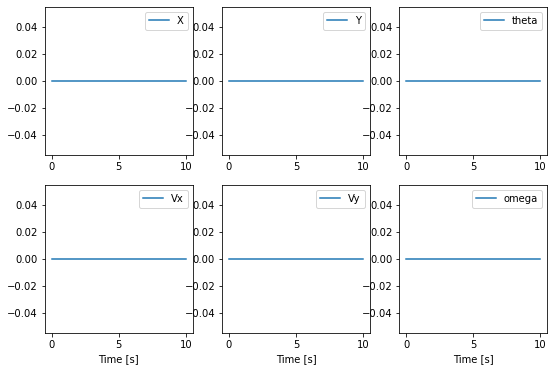

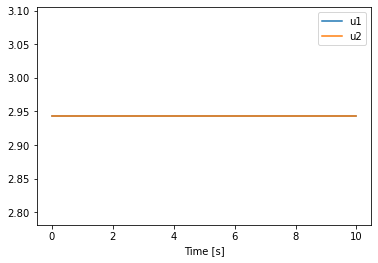

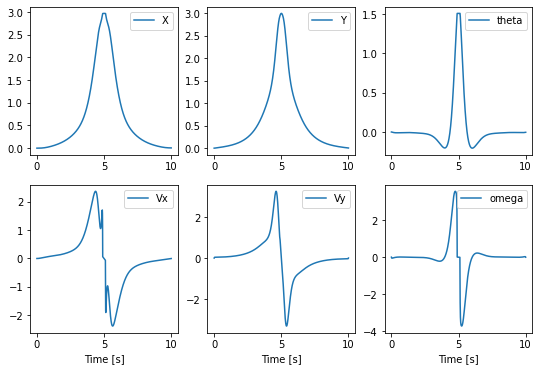

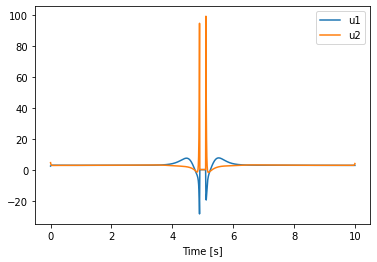

In [6]:
# Drone reaching a vertical orientation

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

# Function which creates state and control costs to promote vertical orientation at t=5
def cost_function(horizon_length):
    list_of_Q = []
    list_of_R = []
    
    z_target = np.array((3,0,3,0,np.pi/2,0)) 
    t_lower_target = 0.49
    t_upper_target = 0.51
    
    Q_tune = 10
    R_tune = 0.1
    
    Q_temp = np.identity(quadrotor.NUMBER_STATES)
    Q_stable = 100*Q_temp
    Q_vertical = 100000*Q_temp
    Q_end = 100000*Q_temp
    
    R_temp = R_tune*np.identity(quadrotor.NUMBER_CONTROLS)
    
    for i in range(horizon_length):
        
        if ((i>=t_lower_target*horizon_length) and(i<=t_upper_target*horizon_length)):
            Q_now = Q_vertical
        
        else:
            Q_now = Q_stable
               
        list_of_Q.append(Q_now)
        list_of_R.append(R_temp)
    
    list_of_Q.append(Q_end)
    return list_of_Q,list_of_R,z_target,t_lower_target,t_upper_target


# Function to compute total cost of current trajectory
def compute_cost(z,u,horizon_length):
    total_cost = 0.

    Qn,Rn, z_target, t_lower_target, t_upper_target = cost_function(horizon_length)
    QN = Qn[horizon_length]
    
    for n in range(horizon_length): 
        if ((n>=t_lower_target*horizon_length) and (n<=t_upper_target*horizon_length)):
            
            total_cost = total_cost + np.transpose(z[:,n]-z_target)@Qn[n]@(z[:,n]-z_target) + np.transpose(u[:,n])@Rn[n]@(u[:,n])

        else:
            total_cost = total_cost + np.transpose(z[:,n])@Qn[n]@(z[:,n]) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
        
    #print("total cost = ",total_cost[0])    
    total_cost = total_cost + np.transpose(z[:,horizon_length])@QN@(z[:,horizon_length])
                                                                                  
    #print("total cost = ",total_cost)
    return total_cost

#Function to return hessian and gradients of cost (Quadratic approximation of the cost)
def get_quadratic_approximation_cost(z, u, horizon_length):
    
    Qn_orig, Rn_orig, z_target, t_lower_target, t_upper_target = cost_function(horizon_length)
    
    QN_orig = Qn_orig[horizon_length]
    
    qN = 2*QN_orig@(z[:,horizon_length])
    QN = 2*QN_orig
    
    Qn = []
    Rn = []
    qn = []
    rn = []
    for j in range(horizon_length):
        if((j>=t_lower_target*horizon_length) and (j<=t_upper_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])

            qn.append(2*Qn_orig[j]@(z[:,j]-z_target))
            rn.append(2*Rn_orig[j]@(u[:,j]))
        else:
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
            qn.append(2*Qn_orig[j]@z[:,j])
            rn.append(2*Rn_orig[j]@(u[:,j]))
    
    Qn.append(QN)
    qn.append(qN)
    return Qn,Rn,qn,rn

# Solve LQR equations for current trajectory
def solve_Riccati_recursion(Q, R,q,r,z_traj, u_traj, N):

    
    k=N-1
    K_gains = []
    k_feedforward = []
    
    P_prev=Q[N]
    p_prev=q[N]
    
    while(k>=0):
        
        A,B = get_linearlization(z_traj[:,k],u_traj[:,k])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@B.transpose()@P_prev@A
        
        Pn = Q[k]+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@(B.transpose()@p_prev+r[k])
        
        pn = q[k]+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        k=k-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    
    return K_gains, k_feedforward

def integrate_dynamics(z0,u_guess,horizon_length):
    
    z_guess=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z_guess[:,0] = z0
    for i1 in range(horizon_length):
        z_guess[:,i1+1] = quadrotor.get_next_state(z_guess[:,i1], u_guess[:,i1])
    return z_guess

# Integrate dynamics
def forward_dynamics(z0,K_g,k_g,horizon_length,alpha):
    
    z=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    for i2 in range(horizon_length):
        u[:,i2] = u[:,i2] + K_gains_curr[i2]@(z_curr[:,i2]-z_guess[:,i2])+k_feedforward_curr[i2]
        z[:,i2+1] = quadrotor.get_next_state(z[:,i2], u[:,i2])
    return z_guess, u_guess

# iLQR algorithm implementation
def solve_iLQR(threshold = 0.000001):
    
    
    #initial guess
    
    T = 10 #seconds
    horizon_length = int(T/quadrotor.DELTA_T)
    
    # Initial guess u =mg/2
    u_guess = np.stack((np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length),np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length)))

    #integrate the system to find z_guess
    z0 = np.zeros([quadrotor.NUMBER_STATES])
    
    z_guess = integrate_dynamics(z0,u_guess,horizon_length)
    
    # Save initial guess
    u_initial = u_guess
    z_initial = z_guess
    
    # Initialize prev cost and current cost
    J_prev = compute_cost(z_guess,u_guess,horizon_length)
    thresh_last =1000
    
    while(thresh_last > threshold):
        
        #Backward pass, each return value is a list
        Qn_curr,Rn_curr,qn_curr,rn_curr = get_quadratic_approximation_cost(z_guess, u_guess, horizon_length)
        
        # Linearize at z_guess[t] and u_guess[t]
        K_gains_curr, k_feedforward_curr = solve_Riccati_recursion(Qn_curr,Rn_curr,qn_curr,rn_curr,z_guess, u_guess, horizon_length)
        
        #Forward pass
        
        #Initialize cost and trajectories
        z_curr = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
        u_curr = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
        z_curr[:,0] = np.zeros([quadrotor.NUMBER_STATES])
        
        for o in range(horizon_length):
            u_curr[:,o] = u_guess[:,o] + K_gains_curr[o]@(z_curr[:,o]-z_guess[:,o])+k_feedforward_curr[o]
            z_curr[:,o+1] = quadrotor.get_next_state(z_curr[:,o],u_curr[:,o])
        
        J_curr = compute_cost(z_curr,u_curr,horizon_length)

        # We now have new states z_curr
        #line search
        if(J_curr>=J_prev):
            alpha = 1
            while(J_curr>=J_prev and alpha>0.01):
                
                z_line = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
                u_line = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
                
                z_line[:,0] = np.zeros([quadrotor.NUMBER_STATES])
                
                for l in range(horizon_length):
                    u_line[:,l] = u_guess[:,l] + K_gains_curr[l]@(z_line[:,l]-z_guess[:,l])+alpha*k_feedforward_curr[l]
                    z_line[:,l+1] = quadrotor.get_next_state(z_line[:,l],u_line[:,l])
                
                J_curr = compute_cost(z_line,u_line,horizon_length)
                if(J_curr<J_prev):
                    # Better trajectory found
                    z_guess = z_line
                    u_guess = u_line
                    thresh_last = J_prev - J_curr
                    J_prev = J_curr
                    break
                else:    
                    # Re-do line search
                    alpha = alpha/2
        else:
            z_guess = z_curr
            u_guess = u_curr
            thresh_last = J_prev - J_curr
            J_prev = J_curr

    return z_initial,u_initial,z_guess, u_guess

z_i,u_i,z_f,u_f=solve_iLQR()
T =10
horizon_length = int(T/quadrotor.DELTA_T)
time = np.arange(0.,(T+quadrotor.DELTA_T), quadrotor.DELTA_T)

# Initial trajectory

t, state_list, u = time, z_i, u_i
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Final trajectories

t, state_list, u = time, z_f, u_f
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Animation

quadrotor.animate_robot(z_f,u_f)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAVvRtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA2OZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAOSq/2+9Zj+im+AAABXQArISJA0agX3rQrxAFVDm
jgk//Zy6/Zkysf1BBlzSMecs0adU4czxdWu3ATn6Hlfa1lvTJVwFeJzzgStuUpMltOrgd3xiXeRy
NijQbA3SBfm/fv33UGxcJxjDaZrIZWJfsESDGQ+3B//+mxNP94N7yss6aV0xf5e1Y3eMSRhlnOEg
5t6laqwn4ehgEZ2RN/0//u4oRdcLYjvj7rDRnH5cb7OVcVeDDGblDP4oiq80WQOVQ/kvRcX6GntS
Tyf2SkA1tyCNIyktbublNs2xhPCwz3kf2rP4S8jvTxqEdS7q8r7UnnwkyNZtsidmfggEoAALuDpT
UqgO2Nyc/nyo2P8mgMLl9W2v4DablAAh40KXLQOiQA0eTXhSNU48dP9tF0wwuFwd4UGlWZaNRk+c
PEQ/GeZ0B3tBqqih8K40vtZGgyZSX/Cllsgqdg87QMUDgaJ7ASAyDb/CkU0nALDfO+cnRvfZl6Sl
9fLa1LK9B3Q1wTbHr5w1s3/m8ux2rJaVHDZCUV/y38xSEO80k+48n4ueT6r6VDh4ujgolzbZLj9d
/49jd6q5J0Apc+ZRvsR0TaOEO5b8o0ujSeIOIgkhOahi4LpV4bVwK7he/ZWo2EuAlsgT8wA30ZbL
wxWrckoxjTmGltHrkOT94ux0DHMECvahXEYWRP8+EZ9m2FtbGM87U5PlU64eUabBTV3Wnsn0B/2R
juUaQEeRisjjK6w9xhThdeSIEFeZ92nFAAADALUJmMzIrlzbZgF1CUqCXUqRwKxHFQu+PTuUm9oT
/Vy3SzoQFPDMT5Ra6nIZNf287fjlo2z/A1D/hXVu69U4jR1B5LgHGGFfma/S8zYm00FY9HJpLUQI
o8vr8x2jOojPA/pyd34cdKKxgRl4bSAipTKY9OevUjE/+kGCaCbwEVK1ZNMeMszFDrRxiXUrh7Wb
eELWicEcHDHF9aCFrlQXQgwzuRotpH7hqg8AMClCEjNHTuf1cVlp78zbFX18BWbBnDYyKYYb6z4D
I7n28etNoeKwPu74SQDdSX/pUDTBJBfj2EmBdn9b2VbHKwoW3v1fsf/IB9Mj+RHjncXc42nxoD4B
R0jtBsp1SSimoT7XFTcuW/CqTgAW1jmNQGw0M3+AB50IvXqyLHRJwmsD/JDqBUInDUUexPX95gu7
HCfCrYWMbYoY44neT8fmFvbJSBwDLB2MPI01U//7laNfFPAYozf1zqHcqw0bcEpH/Z/lmb3g1cxx
K5uu15Wgd76WogCYZkIMvQo2OEY0JaGlYQzDymyxlYiecuBQO2/a2D+3FTTQSeGjP+fIG+1CLxtK
xGeTNF8VgLWfhssjk9enRJLTUXPqTPf7XvgiNewYe3Ki6u93g+xQXNwAdCL+TUbtIRXoKW0DVmOa
y10svjSAqVqjB/4/Zv3sutkkql6zfsu02zBzr4qvc0en/dN+V2dN1MWv1TaE1gkHJIrSrFNpoPK5
quDLrJ/a1c02KjAAAAMAACj2Ox8cNjh/BA2FAm3s99sGT8sE6V9pM5tizhpDbbZKwhxQUAFTu1U+
XY8nKyv/wXEwpkvWM+3vFZ7C9BW44Eo4mRV2J7UoiK3CgHxtqfBuMh/trPQ78dSQihtaept4xFWW
sk03oSTfaB3NEYuuWRIOgL/MVZWY79E2mLsjAeto/GBnxDRolmtK7qsaGc2/IEgGVOUL+tRZ3BvB
Li+l3/oLCb1LuMzE6XrW9pt2Hb6Z0ZbhVg6HPFC2t5tlZ5e22RNDhd4jrrJSsdDit1jt9Pj20Vkj
PW8KaniIk/5F+rpkWHl+sztqWg9HeA3sUKvqLWV5yu0QogX4hFk1T8DSNt6fnmZ0qsnVy2EpQLgC
tuCBdfZ6h+7TVBxCnLkOhXatrBIBJIFGE7DEdl36DB5whrWulWiQKWzMHh61N383gUvxegaf8Kct
3A0Z3LXKc2n6oG8hnI6Itu5JvxeJIkZJ3gEm0qKEbP8f8d5fUYdA0QD33rLryeXP7WsKyi3hIp3h
mI2BdRZrZSfkieLw7ZYmfP1xnYXxfhv7p/s6zrm5gPE3mZmPqHfg4gRdXCH5RC/t9KCQjp4TP3/G
ngpE2z+khqc7B3WUUxQACTp0ZpLtoEYAAAbhSOpIrYANF56BNIMWQL5lBN4v/84Qzz86a2nV+7nB
jcmj496vD/E+9Qy3RsmakmTbWGLreb0+hK+sDsB47wosB5i5mlh+e9EWXEfP91uGH5GqXqJyihAG
121hXKFUdF0abnCWR1Ye/n+/+YcKEfCk/b+1u2Oqda2VyCqZak28aDApyIY0oJiCJqW1vZsn51Xb
2Gl+k3+cjewodWvHnjWIfWTHDy7uiSTvSl8Vus4cLH1zlrPvvNWPI7SJIJypGNC7MMN53Zo/G0mn
w3rLSlXMxR9vetcQKV7y1W02FmYKrgQuxF8cOvVicbXUIIU3jNrTi2kBjHKfk83XBh/8zafczoSF
IaLGG12AtKdomZAAAAMAAAfyOUn5yoq3fCG9cV3JTi6wJ/2H/oX6ictWpam/ZjnZij5QOwi921Ma
99ve/9wZWJTs8NaaGjEBQrMB2HUesKOhPovqM3szwzEwDk9qbsqalqydHSF98aM9w0mVNIljisNd
X19YoAEEglIxeopjz0n5t/uHRXvGpPvWz0ysfUslxfmxmXNx7f7QeRohYTjLX4cARDFWc5y8w9Ma
hpypf+aMXjFtkOtkkY0p+/vWZ98SIV/RQv5hEMIqSqEg2yI+hmgERRi6/LMV0DMi2rzybQYuTWPi
3tXSCUEeoz+8sNx1i0UYVzQWiAf+mtivMAAAAwBOQGBEuQ+jLqUOWlxZhdQwpzJrhJf/Ayz+p8gB
9LSCgfcDHNU4rhww+JE5J

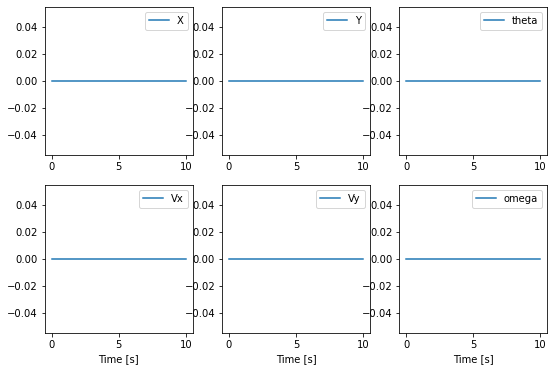

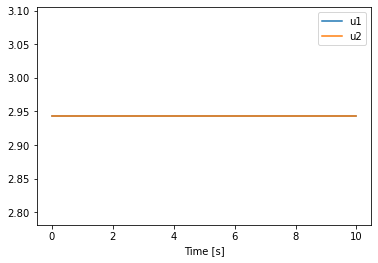

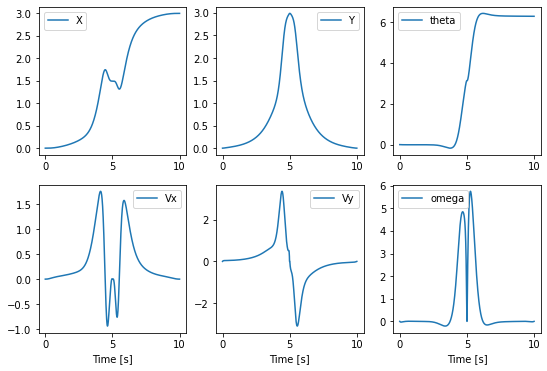

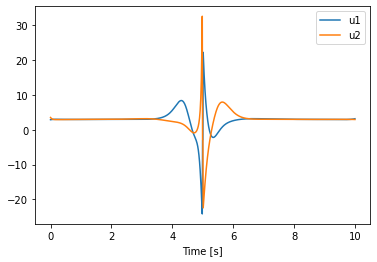

In [7]:
# Drone doing a full flip 

# Function to linearize the dynamics of the drone.
def get_linearlization(z,u):
    A = np.array([[1,quadrotor.DELTA_T,0,0,0,0],[0,1,0,0,-quadrotor.DELTA_T*(u[0]+u[1])*np.cos(z[4])/quadrotor.MASS,0],[0,0,1,quadrotor.DELTA_T,0,0],[0,0,0,1,-quadrotor.DELTA_T*(u[0]+u[1])*np.sin(z[4])/quadrotor.MASS,0],[0,0,0,0,1,quadrotor.DELTA_T],[0,0,0,0,0,1]])
    B = np.array([[0,0],[-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS,-quadrotor.DELTA_T*np.sin(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS,quadrotor.DELTA_T*np.cos(z[4])/quadrotor.MASS],[0,0],[quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA,-quadrotor.DELTA_T*quadrotor.LENGTH/quadrotor.INERTIA]])
    return A,B

# Function which creates state and control costs to promote flipped orientation at t=5 and stabilizes drone at t=10
def cost_function(horizon_length):
    list_of_Q = []
    list_of_R = []
    
    z_target1 = np.array((1.5,0,3,0,np.pi,0)) 
    z_target2 = np.array((3,0,0,0,2*np.pi,0))
    t_lower_target = 0.499
    t_upper_target = 0.501
    
    
    R_tune = 0.1
    
    Q_temp = np.identity(quadrotor.NUMBER_STATES)
    Q1 = 10*Q_temp
    Q2 = 100000*Q_temp
    Q3 = 1*Q_temp
    Q3[4,4] = 10
    Q_end = 100000*Q_temp
    R_temp = R_tune*np.identity(quadrotor.NUMBER_CONTROLS)
    
    for i in range(horizon_length):
        
        if((i<t_lower_target*horizon_length)):
            Q_now = Q1
            
        elif ((i>=t_lower_target*horizon_length)and(i<=t_upper_target*horizon_length)):
            Q_now = Q2    
        else:
            Q_now = Q3
               
        list_of_Q.append(Q_now)
        list_of_R.append(R_temp)
    
    list_of_Q.append(Q_end)
    return list_of_Q,list_of_R,z_target1,z_target2,t_lower_target,t_upper_target


# Function to compute total cost of current trajectory
def compute_cost(z,u,horizon_length):
    total_cost = 0.

    Qn,Rn, z_target1,z_target2, t_lower_target, t_upper_target = cost_function(horizon_length)
    QN = Qn[horizon_length]
    
    for n in range(horizon_length): 
        if(n<t_lower_target*horizon_length):
            total_cost = total_cost + np.transpose(z[:,n])@Qn[n]@(z[:,n]) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
            
        elif ((n>=t_lower_target*horizon_length) and (n<=t_upper_target*horizon_length)):
            total_cost = total_cost + np.transpose(z[:,n]-z_target1)@Qn[n]@(z[:,n]-z_target1) + np.transpose(u[:,n])@Rn[n]@(u[:,n])

        else:
            total_cost = total_cost + np.transpose(z[:,n]-z_target2)@Qn[n]@(z[:,n]-z_target2) + np.transpose(u[:,n])@Rn[n]@(u[:,n])
    #print("total cost = ",total_cost[0])    
    total_cost = total_cost + np.transpose(z[:,horizon_length]-z_target2)@QN@(z[:,horizon_length]-z_target2)
                                                                                  
    #print("total cost = ",total_cost)
    return total_cost

#Function to return hessian and gradients of cost (Quadratic approximation of the cost)
def get_quadratic_approximation_cost(z, u, horizon_length):
    
    Qn_orig, Rn_orig, z_target1,z_target2, t_lower_target, t_upper_target = cost_function(horizon_length)
    
    QN_orig = Qn_orig[horizon_length]
    
    qN = 2*QN_orig@(z[:,horizon_length]-z_target2)
    QN = 2*QN_orig
    
    Qn = []
    Rn = []
    qn = []
    rn = []
    for j in range(horizon_length):
        if((j<t_lower_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
            qn.append(2*Qn_orig[j]@z[:,j])
            rn.append(2*Rn_orig[j]@(u[:,j])) 
            
        elif((j>=t_lower_target*horizon_length) and (j<=t_upper_target*horizon_length)):
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])

            qn.append(2*Qn_orig[j]@(z[:,j]-z_target1))
            rn.append(2*Rn_orig[j]@(u[:,j]))
        
        else:
            Qn.append(2*Qn_orig[j])
            Rn.append(2*Rn_orig[j])
  
            qn.append(2*Qn_orig[j]@(z[:,j]-z_target2))
            rn.append(2*Rn_orig[j]@(u[:,j]))
    
    Qn.append(QN)
    qn.append(qN)
    return Qn,Rn,qn,rn

# Solve LQR equations for current trajectory
def solve_Riccati_recursion(Q, R,q,r,z_traj, u_traj, N):

    
    k=N-1
    K_gains = []
    k_feedforward = []
    
    P_prev=Q[N]
    p_prev=q[N]
    
    while(k>=0):
        
        A,B = get_linearlization(z_traj[:,k],u_traj[:,k])
        
        Kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@B.transpose()@P_prev@A
        
        Pn = Q[k]+A.transpose()@P_prev@A + A.transpose()@P_prev@B@Kn
        
        kn = -np.linalg.inv(B.transpose()@P_prev@B+R[k])@(B.transpose()@p_prev+r[k])
        
        pn = q[k]+A.transpose()@p_prev + A.transpose()@P_prev@B@kn
        
        K_gains.append(Kn)
        k_feedforward.append(kn)
        
        P_prev = Pn
        p_prev = pn
        
        k=k-1
        
    
    K_gains.reverse()
    k_feedforward.reverse()
    
    return K_gains, k_feedforward

def integrate_dynamics(z0,u_guess,horizon_length):
    
    z_guess=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z_guess[:,0] = z0
    for i1 in range(horizon_length):
        z_guess[:,i1+1] = quadrotor.get_next_state(z_guess[:,i1], u_guess[:,i1])
    return z_guess

# Integrate dynamics
def forward_dynamics(z0,K_g,k_g,horizon_length,alpha):
    
    z=np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    for i2 in range(horizon_length):
        u[:,i2] = u[:,i2] + K_gains_curr[i2]@(z_curr[:,i2]-z_guess[:,i2])+k_feedforward_curr[i2]
        z[:,i2+1] = quadrotor.get_next_state(z[:,i2], u[:,i2])
    return z_guess, u_guess

# iLQR algorithm implementation
def solve_iLQR(threshold = 0.0001):
    
    
    #initial guess
    
    T = 10 #seconds
    horizon_length = int(T/quadrotor.DELTA_T)
    
    # Initial guess u =mg/2
    u_guess = np.stack((np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length),np.repeat([quadrotor.MASS*quadrotor.GRAVITY/2],horizon_length)))

    #integrate the system to find z_guess
    z0 = np.zeros([quadrotor.NUMBER_STATES])
    
    z_guess = integrate_dynamics(z0,u_guess,horizon_length)
    
    # Save initial guess
    u_initial = u_guess
    z_initial = z_guess
    
    # Initialize prev cost and current cost
    J_prev = compute_cost(z_guess,u_guess,horizon_length)
    thresh_last =1000
    
    while(thresh_last > threshold):
        
        #Backward pass, each return value is a list
        Qn_curr,Rn_curr,qn_curr,rn_curr = get_quadratic_approximation_cost(z_guess, u_guess, horizon_length)
        
        # Linearize at z_guess[t] and u_guess[t]
        K_gains_curr, k_feedforward_curr = solve_Riccati_recursion(Qn_curr,Rn_curr,qn_curr,rn_curr,z_guess, u_guess, horizon_length)

        #Forward pass
        
        #Initialize cost and trajectories
        z_curr = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
        u_curr = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
        z_curr[:,0] = np.zeros([quadrotor.NUMBER_STATES])
        
        for o in range(horizon_length):
            u_curr[:,o] = u_guess[:,o] + K_gains_curr[o]@(z_curr[:,o]-z_guess[:,o])+k_feedforward_curr[o]

            z_curr[:,o+1] = quadrotor.get_next_state(z_curr[:,o],u_curr[:,o])
        
        J_curr = compute_cost(z_curr,u_curr,horizon_length)

        # We now have new states z_curr
        #line search
        if(J_curr>=J_prev):
            alpha = 1
            while(J_curr>=J_prev and alpha>0.01):
                
                z_line = np.empty([quadrotor.NUMBER_STATES, horizon_length+1])
                u_line = np.empty([quadrotor.NUMBER_CONTROLS, horizon_length])
                
                z_line[:,0] = np.zeros([quadrotor.NUMBER_STATES])
                
                for l in range(horizon_length):
                    u_line[:,l] = u_guess[:,l] + K_gains_curr[l]@(z_line[:,l]-z_guess[:,l])+alpha*k_feedforward_curr[l]
                    z_line[:,l+1] = quadrotor.get_next_state(z_line[:,l],u_line[:,l])
                
                J_curr = compute_cost(z_line,u_line,horizon_length)
                if(J_curr<J_prev):
                    # Better trajectory found
                    z_guess = z_line
                    u_guess = u_line
                    thresh_last = J_prev - J_curr
                    J_prev = J_curr
                    break
                else:    
                    # Re-do line search
                    alpha = alpha/2
        else:
            z_guess = z_curr
            u_guess = u_curr
            thresh_last = J_prev - J_curr
            J_prev = J_curr

    return z_initial,u_initial,z_guess, u_guess

z_i,u_i,z_f,u_f=solve_iLQR()
T =10
horizon_length = int(T/quadrotor.DELTA_T)
time = np.arange(0.,(T+quadrotor.DELTA_T), quadrotor.DELTA_T)

# Initial trajectory

t, state_list, u = time, z_i, u_i
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Final trajectories

t, state_list, u = time, z_f, u_f
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state_list[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state_list[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state_list[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state_list[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state_list[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state_list[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

# Animation

quadrotor.animate_robot(z_f,u_f)